# **EDA Sample Bureau**

## **Table of contents**

* [Our goals](#Our-goals)
* [About the data](#About-the-data)
* [Generalities](#Generalities)
* [Missing values](#Missing-values)
* [Raw features description](#Raw-features-description)
    * [Numerical features](#Numerical-features)
    * [Categorical features](#Categorical-features)
* [Features creation](#Features-creation)
* [Summary](#Summary)

In [1]:
import sys
import os
from pathlib import Path

project_root = str(Path(os.getcwd()).parent)
if project_root not in sys.path:
    sys.path.append(project_root)

from utilities import (
    plot_utilities,
    stat_utilities
)

from utilities.plot_utilities import (
    to_percent,
    plot_triangle_corr_matrix,
    multicolumn_barplot,
    Rstyle_spines,
    plot_num_vs_target,
)
from utilities.stat_utilities import get_missing_values

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

pd.set_option("display.max_columns", 40)

In [2]:
data_dir = "../sample_data/"
sample_bureau = pd.read_parquet(data_dir + "sample_bureau.parquet")

## **Our goals**

<div style="background-color: #f8d7dA; padding: 10px; border-radius: 5px;">
    
In this notebook we aim at:
* **Exploring the Installment Dataset:** Perform EDA to identify potential anomalies.
* **Creating New Features:** Apply aggregation on `SK_ID_CURR`.
* **Building Functions:** Create functions to compute new features and join them with the main dataframe.
* **Visualizing Relationships:** Visualize how the features relate to each other.
</div>

## **About the data**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
    
The bureau dataset contains information collected by Bureau Credit regarding loan applicants' previous loans from institutions other than Home Credit. It is linked to the main application dataset via the key `SK_ID_CURR`. Additionally, more granular details can be accessed through the bureau_balance dataset, which offers insights into the repayment history of each previous loan.

It's important to recognize that Home Credit may lend money to individuals who have never taken out a loan before. Therefore, when merging this information with our main dataset, we need to account for the fact that some current applicants may not appear in the bureau dataset. Our aim is to extract meaningful features from this data to enhance our classifier. The underlying assumption is that individuals with a poor loan history are more likely to default compared to those with a good loan history or no prior loans at all.
</div>

## **Generalities**

In [3]:
sample_bureau.info()

<class 'pandas.core.frame.DataFrame'>
Index: 293689 entries, 7 to 1716425
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   SK_ID_CURR              293689 non-null  int32   
 1   SK_ID_BUREAU            293689 non-null  int32   
 2   CREDIT_ACTIVE           293689 non-null  category
 3   CREDIT_CURRENCY         293689 non-null  category
 4   DAYS_CREDIT             293689 non-null  int16   
 5   CREDIT_DAY_OVERDUE      293689 non-null  int16   
 6   DAYS_CREDIT_ENDDATE     275603 non-null  float32 
 7   DAYS_ENDDATE_FACT       184623 non-null  float32 
 8   AMT_CREDIT_MAX_OVERDUE  102946 non-null  float64 
 9   CNT_CREDIT_PROLONG      293689 non-null  int8    
 10  AMT_CREDIT_SUM          293688 non-null  float64 
 11  AMT_CREDIT_SUM_DEBT     249135 non-null  float64 
 12  AMT_CREDIT_SUM_LIMIT    195020 non-null  float64 
 13  AMT_CREDIT_SUM_OVERDUE  293689 non-null  float64 
 14  CREDIT_T

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">

The bureau dataset contains extensive information about previous loans registered in the Credit Bureau databases. It includes the following features:

* **`CREDIT_ACTIVE`:** Status of each contracted loan.
* **`CREDIT_CURRENCY`:** Currency of each loan.
* **`DAYS_CREDIT`:** When the loan contract started (number of days before the current loan application).
* **`DAYS_CREDIT_ENDDATE`:** Expected end date of the loan contract.
* **`DAYS_ENDDATE_FACT`:** Actual end date of the loan contract.
* **`CREDIT_DAY_OVERDUE`:** Number of days past due on Credit Bureau credit at the time of the related loan application.
* **`AMT_CREDIT_MAX_OVERDUE`:** Maximum amount overdue on the Credit Bureau credit to date.
* **`CNT_CREDIT_PROLONG`:** Number of times the credit was prolonged.
* **`AMT_CREDIT_SUM`:** Current credit amount for the Credit Bureau credit.
* **`AMT_CREDIT_SUM_DEBT`:** Current debt on the Credit Bureau credit.
* **`AMT_CREDIT_SUM_LIMIT`:** Current credit limit of the credit card reported in the Credit Bureau.
* **`AMT_CREDIT_SUM_OVERDUE`:** Current amount overdue on the Credit Bureau credit.
* **`CREDIT_TYPE`:** Type of loan contract.
* **`AMT_ANNUITY`:** Annuity payment for the loan.

</div>

## **Missing values**

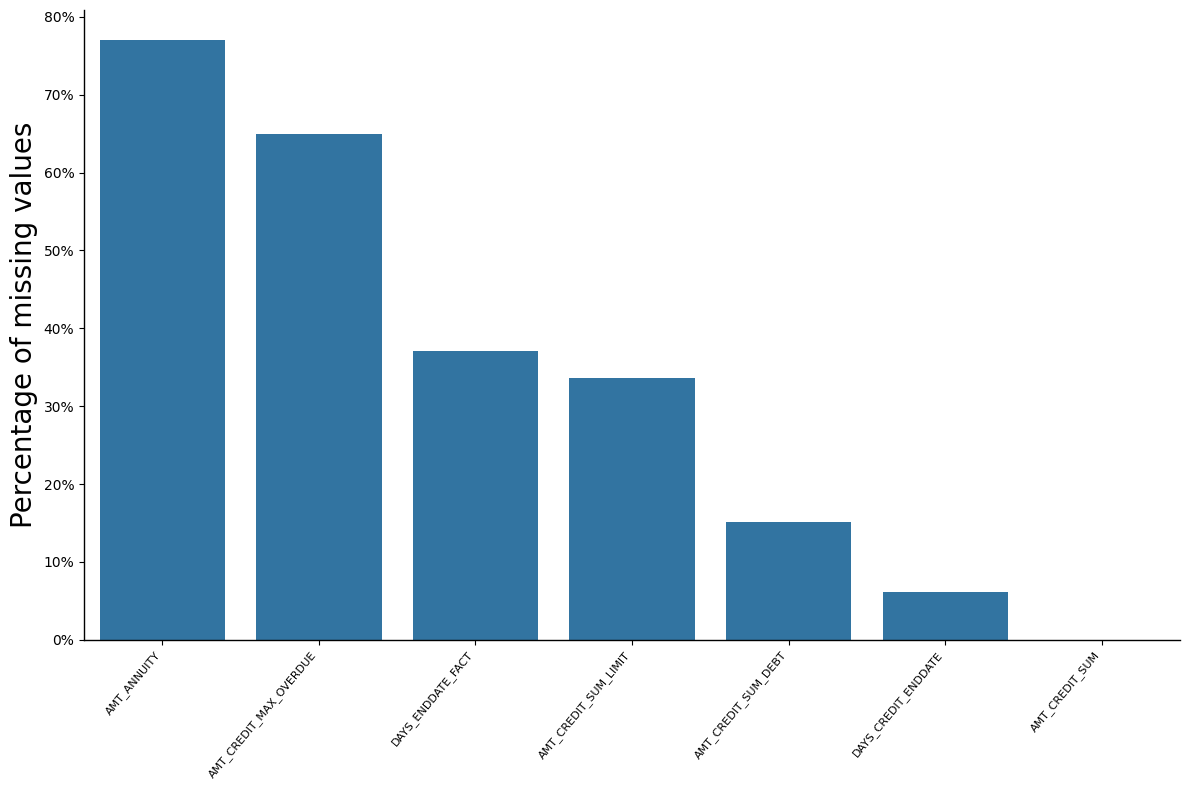

In [4]:
fig, ax = plt.subplots(figsize=(12, 8))
bureau_na = get_missing_values(sample_bureau)
bureau_na = bureau_na[bureau_na["Count"] > 0]
sns.barplot(bureau_na, x=bureau_na.index, y="Percent", ax=ax)
Rstyle_spines(ax, lw=1)
ax.set_xticks(range(0, len(bureau_na.index)))
ax.set_xticklabels(bureau_na.index, rotation=50, ha="right", fontsize=8)
ax.yaxis.set_major_formatter(FuncFormatter(to_percent))
ax.set_xlabel("")
ax.set_ylabel("Percentage of missing values", fontsize=20)
plt.tight_layout()

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">

We have some features with a significant amount of missing values. For example:
* **`AMT_ANNUITY`:** This feature is not applicable to every loan, as there are various repayment strategies. Additionally, some loan companies might keep the annuities they charge confidential.
* **`AMT_CREDIT_MAX_OVERDUE`:** This value is provided only if there has been an overdue payment.
* **`DAYS_ENDDATE_FACT`:** This feature is left blank for loans that are still active and have not yet ended.
* **`AMT_CREDIT_SUM_LIMIT`:** This feature is specific to credit cards and may not apply to other types of loans.
* **`AMT_CREDIT_SUM_DEBT`:** This value is only relevant if there is existing debt for the loan.

</div>

## **Raw features description**

### **Numerical features**

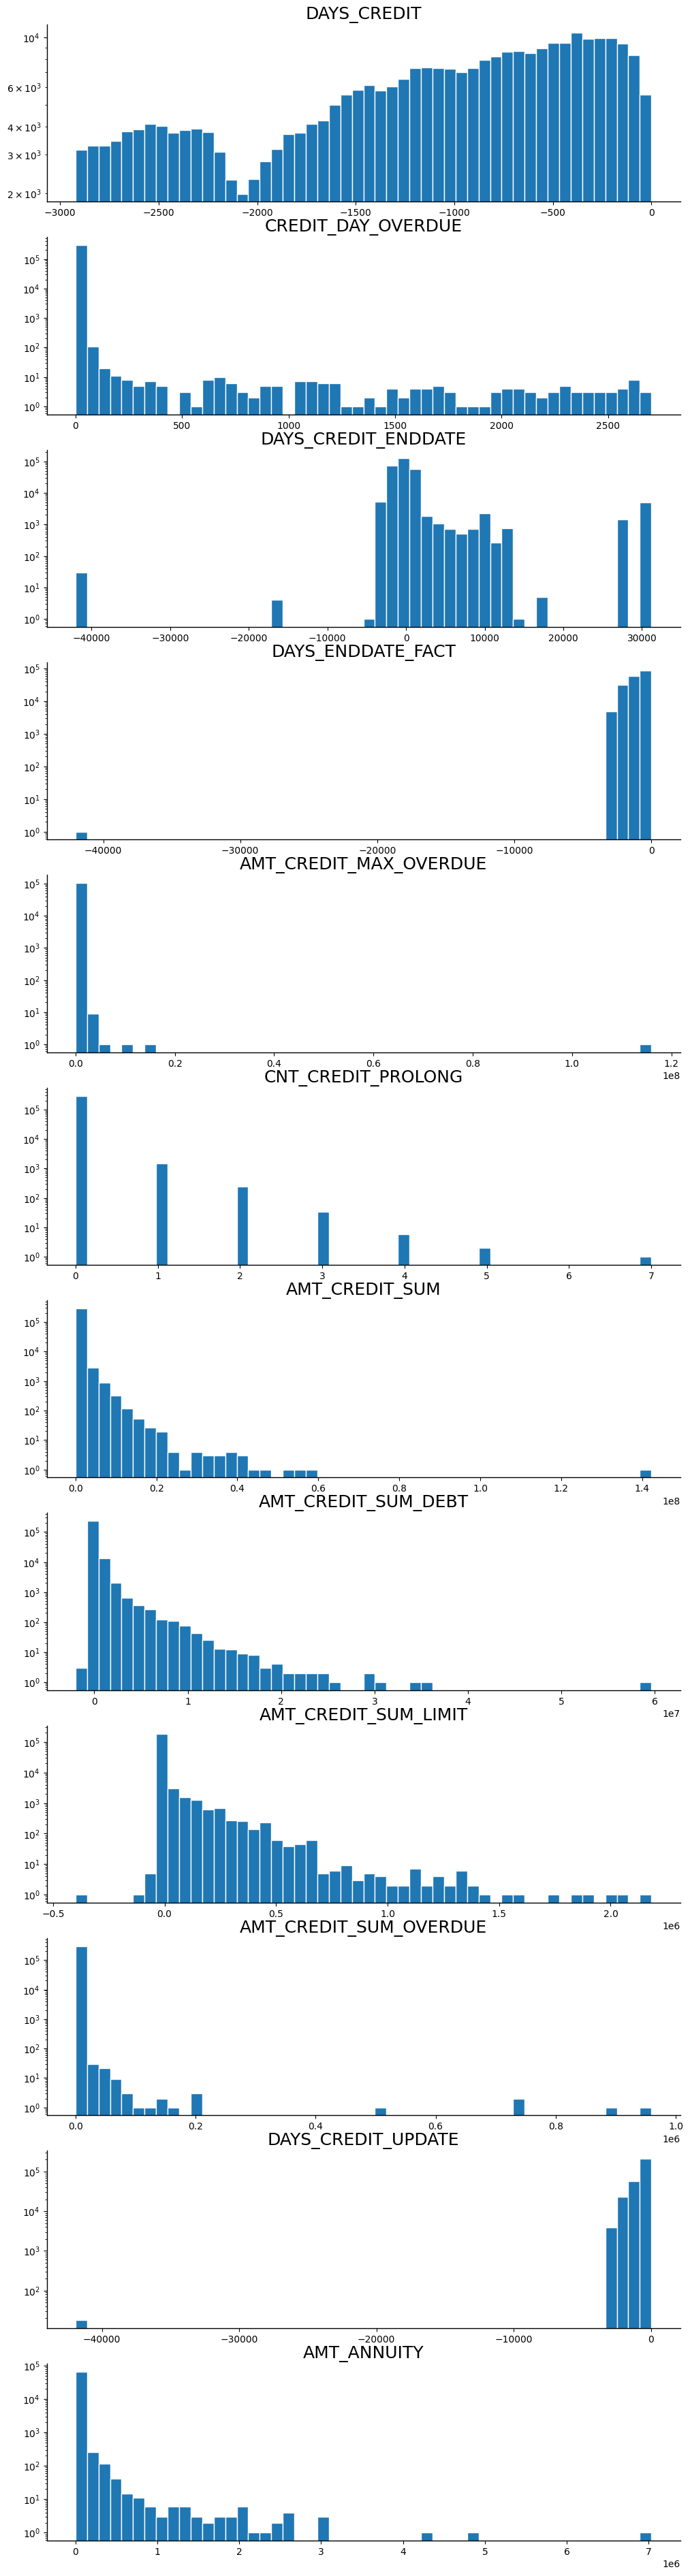

In [5]:
bur_num_cols = [
    col
    for col in sample_bureau.select_dtypes(include="number").columns
    if not col.startswith(("SK_ID_BUREAU", "SK_ID_CURR"))
]
fig, axs = plt.subplots(len(bur_num_cols), 1, figsize=(12, 4 * len(bur_num_cols)))
for i, feature in enumerate(bur_num_cols):
    N, bins, patches = axs[i].hist(
        sample_bureau[feature], bins=50, color="C0", edgecolor="w"
    )
    axs[i].set_yscale("log")
    axs[i].set_title(feature, fontsize=18)
    Rstyle_spines(axs[i], lw=1)

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
We have identified several anomalies from the graphs above:

* **`DAYS_CREDIT_ENDDATE`:** We found that some end dates were more than 40 years in the past (and over 100 years for some), while others were over 80 years in the future. We'll treat any `DAYS_CREDIT_ENDDATE` values exceeding 15,000 days (approximately 40 years, reasonable for a mortgage) in absolute terms as missing values. Generally speaking, a reasonable duration for a credit (loan) depends on the type of loan, the lender's policies, and the borrower's financial situation. Here's a breakdown of common loan durations:
    * **Personal Loans:** Typically 2 to 7 years.
    * **Auto Loans:** Typically 3 to 7 years.
    * **Mortgages (Home Loans):** Most common durations are 15, 20, or 30 years. In rare cases, 40-year mortgages are offered, but they tend to have higher interest rates.
    * **Student Loans:** Repayment periods can range from 10 to 25 years, with options for income-driven repayment plans lasting up to 30 years.
* **`DAYS_ENDDATE_FACT`:** An anomaly was detected where the credit was marked as terminated over a century ago. We'll apply the same criteria as for `DAYS_CREDIT_ENDDATE`, treating values exceeding 15,000 days as missing.
* **`AMT_CREDIT_MAX_OVERDUE` & `AMT_CREDIT_SUM`:** We found values exceeding 100 million for both, associated with the same loan (a mortgage). While high values are expected for mortgages, these still seem anomalous and will be treated accordingly.
* **`AMT_CREDIT_SUM_DEBT`:** An extreme value exceeding 50 million was found, and several other rows had debt amounts in the tens of millions. We will set a threshold of 50 million and treat anything above that as anomalous.
* **`DAYS_CREDIT_UPDATE`:** We found anomalies similar to other days-related features and will apply the same threshold approach as with `DAYS_CREDIT_ENDDATE`.
</div>

In [6]:
sample_bureau[sample_bureau["SK_ID_BUREAU"] == 6376438]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
731333,406694,6376438,Closed,currency 1,-2412,0,4870.0,-657.0,115987185.0,0,15300000.0,NaN,NaN,0.0,Mortgage,-651,0.0


In [7]:
sample_bureau.loc[
    np.abs(sample_bureau["DAYS_CREDIT_ENDDATE"]) > 15000, "DAYS_CREDIT_ENDDATE"
] = np.nan
sample_bureau.loc[
    np.abs(sample_bureau["DAYS_ENDDATE_FACT"]) > 15000, "DAYS_ENDDATE_FACT"
] = np.nan
sample_bureau.loc[
    np.abs(sample_bureau["DAYS_CREDIT_UPDATE"]) > 15000, "DAYS_CREDIT_UPDATE"
] = np.nan
sample_bureau.loc[
    np.abs(sample_bureau["AMT_CREDIT_MAX_OVERDUE"]) > 1e8, "AMT_CREDIT_MAX_OVERDUE"
] = np.nan
sample_bureau.loc[
    np.abs(sample_bureau["AMT_CREDIT_SUM"]) > 1e8, "AMT_CREDIT_SUM"
] = np.nan
sample_bureau.loc[
    np.abs(sample_bureau["AMT_CREDIT_SUM_DEBT"]) > 5e7, "AMT_CREDIT_SUM_DEBT"
] = np.nan

### **Categorical features**

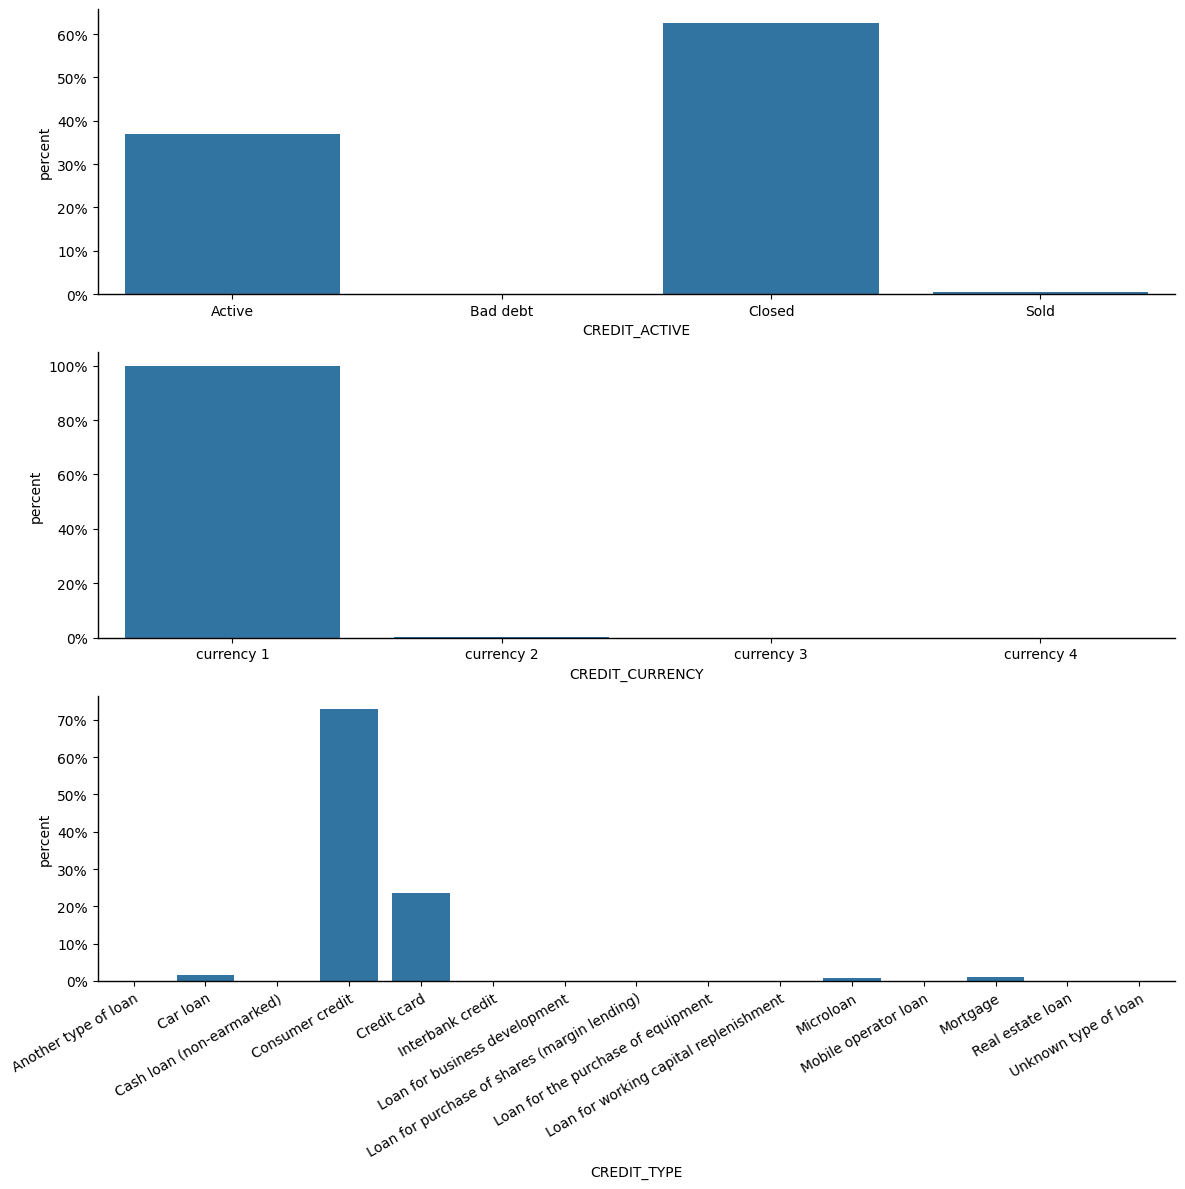

In [8]:
bur_cat_cols = list(sample_bureau.select_dtypes(include="category").columns.values)
fig, axs = plt.subplots(len(bur_cat_cols), 1, figsize=(12, 4 * len(bur_cat_cols)))
for i, feature in enumerate(bur_cat_cols):
    sns.countplot(data=sample_bureau, x=feature, ax=axs[i], stat="percent")
    Rstyle_spines(axs[i], lw=1)
    axs[i].yaxis.set_major_formatter(FuncFormatter(to_percent))
    if sample_bureau[feature].nunique() > 8:
        plt.setp(
            axs[i].get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor"
        )
plt.tight_layout()

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
Here are a few observations and ideas from the above graphs:

* It might be useful to differentiate between Active and Closed accounts when gathering information about previous loans. For instance, we could examine debt but only for active accounts.
* The predominant currency (likely the dollar) is overwhelmingly represented, making the currency feature seem irrelevant, so we’ll exclude it from further analysis.
* There are too many different credit types to handle effectively. We’ll focus only on Consumer credit, Credit card, Car loan, Microloan, and Mortgage, while categorizing the rest as "Others."
</div>

## **Features creation**

In [9]:
def clean_df_bureau(df_bur: pd.DataFrame) -> pd.DataFrame:
    df_bur.loc[
        np.abs(df_bur["DAYS_CREDIT_ENDDATE"]) > 15000, "DAYS_CREDIT_ENDDATE"
    ] = np.nan
    df_bur.loc[
        np.abs(df_bur["DAYS_ENDDATE_FACT"]) > 15000, "DAYS_ENDDATE_FACT"
    ] = np.nan
    df_bur.loc[
        np.abs(df_bur["DAYS_CREDIT_UPDATE"]) > 15000, "DAYS_CREDIT_UPDATE"
    ] = np.nan
    df_bur.loc[
        np.abs(df_bur["AMT_CREDIT_MAX_OVERDUE"]) > 1e8, "AMT_CREDIT_MAX_OVERDUE"
    ] = np.nan
    df_bur.loc[np.abs(df_bur["AMT_CREDIT_SUM"]) > 1e8, "AMT_CREDIT_SUM"] = np.nan
    df_bur.loc[
        np.abs(df_bur["AMT_CREDIT_SUM_DEBT"]) > 5e7, "AMT_CREDIT_SUM_DEBT"
    ] = np.nan

    return df_bur

In [10]:
def compute_agg_bureau_features(df_bur: pd.DataFrame) -> pd.DataFrame:
    # We compute the necessary additional features
    df_bur["CREDIT_DURATION"] = df_bur["DAYS_CREDIT_ENDDATE"] - df_bur["DAYS_CREDIT"]
    df_bur["EFFECTIVE_CREDIT_DURATION"] = (
        df_bur["DAYS_ENDDATE_FACT"] - df_bur["DAYS_CREDIT"]
    )
    df_bur["RATIO_ANNUITY_AMT_CREDIT"] = df_bur["AMT_ANNUITY"] / (
        df_bur["AMT_CREDIT_SUM"] + 0.0001
    )
    df_bur["RATIO_CURRENT_DEBT_CREDIT"] = df_bur["AMT_CREDIT_SUM_DEBT"] / (
        df_bur["AMT_CREDIT_SUM"] + 0.0001
    )
    df_bur["RATIO_CNT_PROLONGED_DURATION"] = df_bur["CNT_CREDIT_PROLONG"] / (
        df_bur["CREDIT_DURATION"] + 0.0001
    )
    df_bur["RATIO_AMT_CREDIT_LIMIT"] = df_bur["AMT_CREDIT_SUM"] / (
        df_bur["AMT_CREDIT_SUM_LIMIT"] + 0.0001
    )
    df_bur["RATION_SUM_OVERDUE_CREDIT"] = df_bur["AMT_CREDIT_SUM_OVERDUE"] / (
        df_bur["AMT_CREDIT_SUM"] + 0.0001
    )

    credit_type_cats = [
        "Consumer credit",
        "Credit card",
        "Car loan",
        "Microloan",
        "Mortgage",
    ]
    df_bur["CREDIT_TYPE_MOD"] = df_bur["CREDIT_TYPE"].apply(
        lambda x: x if x in credit_type_cats else "OTHER"
    )
    credit_type_dummies = pd.get_dummies(
        df_bur["CREDIT_TYPE_MOD"], dtype=np.int8, prefix="CREDIT_TYPE"
    )
    credit_type_dummies.columns = [
        col.replace(" ", "_").upper() for col in credit_type_dummies.columns.values
    ]
    agg_credit_type = {col: "sum" for col in credit_type_dummies.columns}

    df_bur.drop("CREDIT_TYPE", axis=1, inplace=True)
    df_bur = pd.concat([df_bur, credit_type_dummies], axis=1)

    all_features = []
    cats_to_agg = ["Active", "Closed"]
    for cat in cats_to_agg:
        df_filtered = df_bur[df_bur["CREDIT_ACTIVE"] == cat]

        agg_dict = {
            "DAYS_CREDIT": ["min", "max"],
            "AMT_CREDIT_SUM": ["sum", "max"],
            "AMT_CREDIT_SUM_DEBT": ["sum", "max"],
            "CREDIT_DURATION": ["mean", "min", "max"],
            "EFFECTIVE_CREDIT_DURATION": ["mean", "min", "max"],
            "RATIO_ANNUITY_AMT_CREDIT": ["mean"],
            "RATIO_CURRENT_DEBT_CREDIT": ["mean"],
            "RATIO_CNT_PROLONGED_DURATION": ["mean"],
            "RATIO_AMT_CREDIT_LIMIT": ["mean"],
            "RATION_SUM_OVERDUE_CREDIT": ["mean"],
        }
        agg_dict.update(agg_credit_type)

        tmp_bureau_features = df_bur.groupby("SK_ID_CURR").agg(agg_dict)
        tmp_bureau_features.columns = [
            "BUREAU_" + cat.upper() + "_" + "_".join(col).upper()
            for col in tmp_bureau_features.columns.values
        ]
        all_features.append(tmp_bureau_features)

    bureau_features = pd.concat(all_features, axis=1)
    return bureau_features.fillna(0)

In [11]:
def compute_features_bureau(df_bur: pd.DataFrame) -> pd.DataFrame:
    df_bur_ = df_bur.copy()

    # We first clean the dataset to remove anomalies
    df_bur_ = clean_df_bureau(df_bur_)

    # Compute the second agg features (over SK_ID_CURR)
    bur_features = compute_agg_bureau_features(df_bur_)

    return bur_features

In [12]:
bur_features = compute_features_bureau(sample_bureau)
bur_features.head(5)

,BUREAU_ACTIVE_DAYS_CREDIT_MIN,BUREAU_ACTIVE_DAYS_CREDIT_MAX,BUREAU_ACTIVE_AMT_CREDIT_SUM_SUM,BUREAU_ACTIVE_AMT_CREDIT_SUM_MAX,BUREAU_ACTIVE_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_ACTIVE_AMT_CREDIT_SUM_DEBT_MAX,BUREAU_ACTIVE_CREDIT_DURATION_MEAN,BUREAU_ACTIVE_CREDIT_DURATION_MIN,BUREAU_ACTIVE_CREDIT_DURATION_MAX,BUREAU_ACTIVE_EFFECTIVE_CREDIT_DURATION_MEAN,BUREAU_ACTIVE_EFFECTIVE_CREDIT_DURATION_MIN,BUREAU_ACTIVE_EFFECTIVE_CREDIT_DURATION_MAX,BUREAU_ACTIVE_RATIO_ANNUITY_AMT_CREDIT_MEAN,BUREAU_ACTIVE_RATIO_CURRENT_DEBT_CREDIT_MEAN,BUREAU_ACTIVE_RATIO_CNT_PROLONGED_DURATION_MEAN,BUREAU_ACTIVE_RATIO_AMT_CREDIT_LIMIT_MEAN,BUREAU_ACTIVE_RATION_SUM_OVERDUE_CREDIT_MEAN,BUREAU_ACTIVE_CREDIT_TYPE_CAR_LOAN_SUM,BUREAU_ACTIVE_CREDIT_TYPE_CONSUMER_CREDIT_SUM,BUREAU_ACTIVE_CREDIT_TYPE_CREDIT_CARD_SUM,...,BUREAU_CLOSED_AMT_CREDIT_SUM_MAX,BUREAU_CLOSED_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_CLOSED_AMT_CREDIT_SUM_DEBT_MAX,BUREAU_CLOSED_CREDIT_DURATION_MEAN,BUREAU_CLOSED_CREDIT_DURATION_MIN,BUREAU_CLOSED_CREDIT_DURATION_MAX,BUREAU_CLOSED_EFFECTIVE_CREDIT_DURATION_MEAN,BUREAU_CLOSED_EFFECTIVE_CREDIT_DURATION_MIN,BUREAU_CLOSED_EFFECTIVE_CREDIT_DURATION_MAX,BUREAU_CLOSED_RATIO_ANNUITY_AMT_CREDIT_MEAN,BUREAU_CLOSED_RATIO_CURRENT_DEBT_CREDIT_MEAN,BUREAU_CLOSED_RATIO_CNT_PROLONGED_DURATION_MEAN,BUREAU_CLOSED_RATIO_AMT_CREDIT_LIMIT_MEAN,BUREAU_CLOSED_RATION_SUM_OVERDUE_CREDIT_MEAN,BUREAU_CLOSED_CREDIT_TYPE_CAR_LOAN_SUM,BUREAU_CLOSED_CREDIT_TYPE_CONSUMER_CREDIT_SUM,BUREAU_CLOSED_CREDIT_TYPE_CREDIT_CARD_SUM,BUREAU_CLOSED_CREDIT_TYPE_MICROLOAN_SUM,BUREAU_CLOSED_CREDIT_TYPE_MORTGAGE_SUM,BUREAU_CLOSED_CREDIT_TYPE_OTHER_SUM
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100003,-2586,-606,1017400.50,810000.0,0.00,0.0,856.250000,152.0,1822.0,568.333313,154.0,1096.0,0.0,0.000000,0.0,5.185013e+08,0.0,0,2,2,...,810000.0,0.00,0.0,856.250000,152.0,1822.0,568.333313,154.0,1096.0,0.0,0.000000,0.0,5.185013e+08,0.0,0,2,2,0,0,0
100026,-1644,-148,5625000.00,2700000.0,3477814.38,2542576.5,1095.500000,365.0,1826.0,728.000000,728.0,728.0,0.0,0.817232,0.0,2.025000e+10,0.0,0,2,0,...,2700000.0,3477814.38,2542576.5,1095.500000,365.0,1826.0,728.000000,728.0,728.0,0.0,0.817232,0.0,2.025000e+10,0.0,0,2,0,1,0,0
100030,-1547,-418,643430.97,508500.0,451642.50,432301.5,844.799988,92.0,1827.0,404.500000,62.0,1129.0,0.0,0.213325,0.0,9.973850e+08,0.0,0,4,2,...,508500.0,451642.50,432301.5,844.799988,92.0,1827.0,404.500000,62.0,1129.0,0.0,0.213325,0.0,9.973850e+08,0.0,0,4,2,0,0,0
100031,-1365,-75,3970651.50,1350000.0,1125000.00,1125000.0,1095.800049,365.0,1461.0,316.250000,130.0,493.0,0.0,0.500000,0.0,0.000000e+00,0.0,0,5,2,...,1350000.0,1125000.00,1125000.0,1095.800049,365.0,1461.0,316.250000,130.0,493.0,0.0,0.500000,0.0,0.000000e+00,0.0,0,5,2,0,0,0
100039,-1485,-90,4489092.00,2341746.0,2438748.00,1830429.0,775.250000,58.0,1826.0,151.000000,58.0,342.0,0.0,0.240409,0.0,1.170873e+10,0.0,2,5,2,...,2341746.0,2438748.00,1830429.0,775.250000,58.0,1826.0,151.000000,58.0,342.0,0.0,0.240409,0.0,1.170873e+10,0.0,2,5,2,0,0,0


<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">

We have computed various features from the Credit Bureau dataset. In the final pipeline, this newly created dataset will be merged with the main one, along with other datasets. Of course, some loan applicants may not yet have a loan with Home Credit, so they might be missing (i.e., no `SK_ID_CURR`). In such cases, the features we've created can easily be imputed with 0 for absent applicants.

Next, we'll explain and demonstrate how this step will be implemented in the future. Our pipeline needs to be both flexible and efficient, ensuring we only extract the necessary amount of information. For example, if we take a slice of the main dataframe (say, for cross-validation), we will extract the corresponding slice from other datasets. To achieve this, we will identify the `SK_ID_CURR` values from the main dataframe and retrieve only the relevant rows containing these `SK_ID_CURR` values in the other datasets. However, since our sample datasets were created specifically for this purpose, we'll simply demonstrate the process of pre-joining and joining. This way, we can observe how the newly created features relate to each other as well as to the target variable.
</div>

In [13]:
def join_bureau_with_app(
    app_df: pd.DataFrame, features_bur: pd.DataFrame
) -> pd.DataFrame:
    sk_id_curr = pd.DataFrame(index=app_df.index)
    pre_joined = sk_id_curr.join(features_bur, how="left").fillna(0)

    joined = app_df.join(pre_joined, how="left")
    return joined

In [14]:
sample_app = pd.read_parquet(
    data_dir + "sample_application.parquet", columns=["SK_ID_CURR", "TARGET"]
)
sample_app.set_index("SK_ID_CURR", inplace=True)
bur_and_target = join_bureau_with_app(sample_app, bur_features)

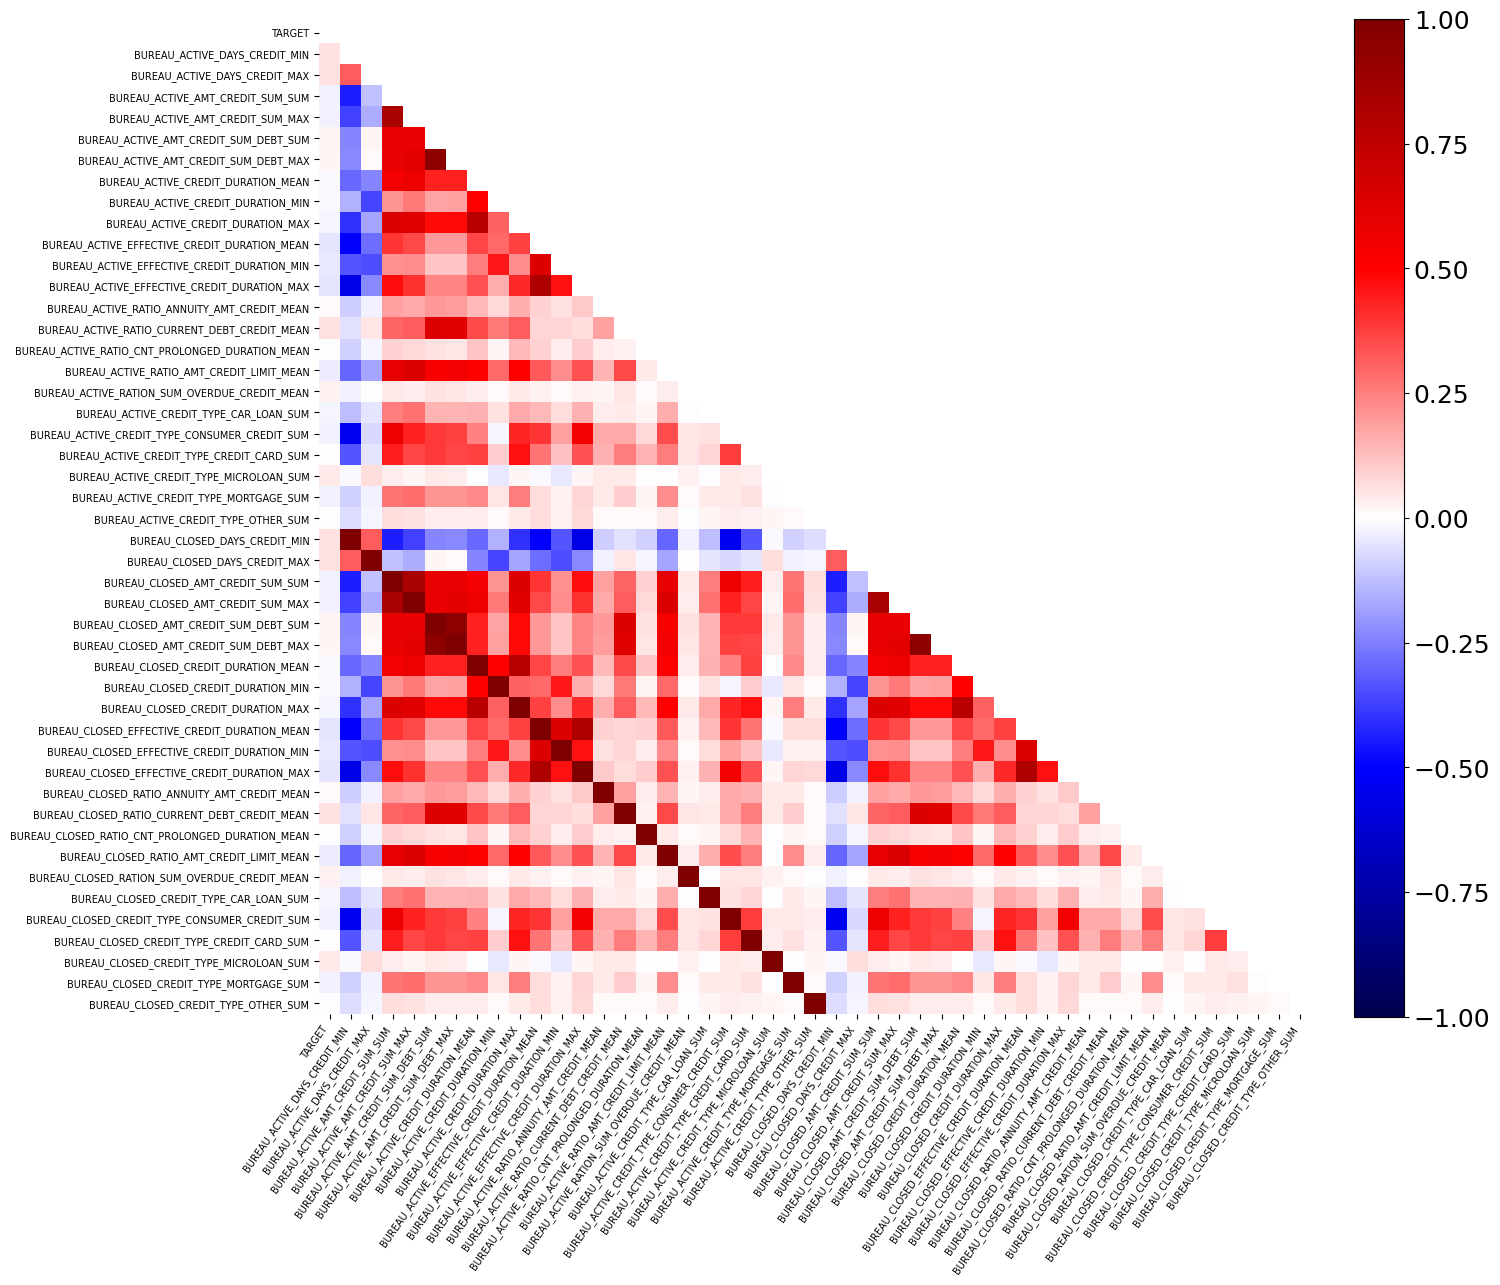

In [15]:
num_corr = bur_and_target.corr(method="kendall")
fig, ax = plt.subplots(figsize=(14, 14))
plot_triangle_corr_matrix(num_corr, ax=ax, ticks_fs=7)

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
A few observations should be noted:

* We've computed many features that show a lot of similarities, with some being nearly identical, as indicated by a Kendall correlation coefficient close to 1. We are aware that accumulating such features could slow down our pipeline and potentially lead to overfitting. For now, we will proceed by training our first model with all the features combined, and later, we'll perform feature selection where many of these redundant features may be removed.
* Some of the new features show a slight relationship with the target variable, which is a positive sign for validating our approach. However, it doesn't yet tell us how these features will interact with others during model training.
</div>

## **Summary**

<div style="background-color: #f8d7dA; padding: 10px; border-radius: 5px;">
Here is a summary of our findings and actions:

* During the EDA, we identified some missing values. No strategy was yet found to impute them, but since they were just an infinitesimal fraction of the dataset, this should not matter much. We've also identified anomalies that we've decided to treat as if they were missing values.
* We created 46 new features through a two-stage aggregation process. Some of these features are highly correlated with each other, which could pose issues later on (e.g., overfitting, reduced efficiency). Also some features have no variance since no occurence of it was found after the two stages aggregation. However, a few show a small but noticeable correlation with the target variable, making them potentially valuable.
* We developed the functions that will be used to compute these features and merge them with the main dataframe in the final pipeline.
</div>